# FCHL in One Notebook
This notebook is designed to explain the ["FCHL" machine learning technique](https://aip.scitation.org/doi/full/10.1063/1.5020710) from 2018.
FCHL is a
- [ ] kernel method
- [ ] created with atomistic, scalable kernels
- [ ] that use "alchemical" many-body similarity functions
- [ ] to regress atomic properties with ridge regression.

Our goal in this notebook is to explain what each of those bullets means.
We will presume that you are familiar, in general, with regression methods and how to use the PyData stack (e.g., numpy, pandas, sklearn).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from qml.fchl import get_local_kernels, get_local_symmetric_kernels
from qml import Compound
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_absolute_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from scipy.stats import linregress
from time import perf_counter
from io import StringIO
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

## Kernel Methods
The ["kernel" trick](https://en.wikipedia.org/wiki/Kernel_method) is make a supervised learning problem easier by creating new input features based on pairwise similarities between a new input point and each point from the training set. The kernel creates a new set of $N$ features where each feature is the similarity between a certain entry and each of $N$ points from the training set. The similiarity function used to compute the new features is called _the kernel_.

Here, we will demonstrate how the kernel can drastically simplify the learning problem.

In [2]:
x = np.arange(-2, 2.1, 1)
y = (-1 <= x) & (x <= 1)

Text(0.5, 0, '$x$')

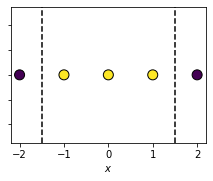

In [3]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(x, [0]*5, c=y, s=100, ec='k')
ax.set_ylim(ax.get_ylim())
for i in [-1.5, 1.5]:
    ax.plot([i]*2, ax.get_ylim(), 'k--')

ax.set_yticklabels([])
ax.set_xlabel('$x$')

Note how this problem is not linearly separable. You need 2 rules to separate the two classes.

Now, we apply a kernel trick to create a new set of features. We use the ["RBF Kernel"](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html)
to generate new features. The RBF kernel uses a Gaussian function to create new features

$f_i = k(x, x_i) = \exp(-(x - x_i)^2/\sigma))$

Applying the kernel function to all of the data yields the so-called, "kernel matrix" where

$K_{ij} = k(x_i, y_j)$

We will use this term in the remainder of the notebook

In [4]:
f = rbf_kernel(x[:, None])

Text(0.5, 0, '$x$')

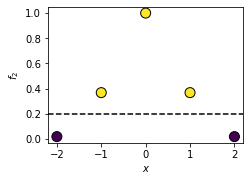

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(x, f[:, 2], c=y, s=100, ec='k')
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [0.2]*2, 'k--')

ax.set_ylabel('$f_2$')
ax.set_xlabel('$x$')

Now my features are linear separable based on $f_2$. We've made the learning problem easier by transforming the data to a new space.

FCHL operates based on this idea of "apply a similiarty function to make learning easier." The secret is finding a function that maps "materials" into a similiarly easy space for ML to learn a simple function

## Atomistic Kernel
The first concept used by FCHL is the notion of a atomistics kernel, which leverages the fact that many molecular properties can be represented as sums over atomic properties.
Energy is a good example due to most quantum effects being local: two atoms with similar _local_ environemnts should have similiar energies.
An atomistic kernel definies the kernel (read: similarity) function between two molecules as a sum over kernels describe each atom:

$K(x, y) = \sum_i \sum_j k(x_i, y_j)$

Here, we show how that simplifies molecular machine learning.

Consider an (artificial) case where we have a single molecule where the atom's local environment can be described by a feature vector: `[1]`

We assign it an energy of -1

In [6]:
molA = np.ones((1, 1))
molA

array([[1.]])

We assume an energy model based on a kernel regression: $E(x) = \sum_i K(x, x_i)$ where $x_i$ is a molecule from the training set and $\alpha_i$ is a learned parameter

In [7]:
def scalable_kernel(x: np.ndarray, y: np.ndarray) -> float:
    """Compute a scalable kernel
    
    Args:
        x: 2D representation for a molecule
        y: 2D representation for a second molecule
    """
    
    k = rbf_kernel(x, y)
    return k.sum()

Solving for the only learned parameter, $\alpha_0$: $E(molA) = \alpha_0 \times K(molA, molA)$

In [8]:
alpha_0 = -1 / scalable_kernel(molA, molA)
print(f'alpha_0 = {alpha_0:.2f}')

alpha_0 = -1.00


We now predict the properties of several molecules which have atoms with similar environemnts but with different numbers of atoms

Text(0, 0.5, 'Energy')

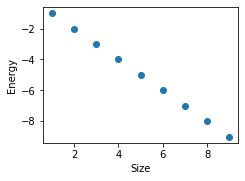

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

n = np.arange(1, 10, 1)
e = [alpha_0 * scalable_kernel(np.ones((i, 1)), molA) for i in n]

ax.scatter(n, e)

ax.set_xlabel('Size')
ax.set_ylabel('Energy')

The scalable kernel captures the scaling between molecule size and energy by construction.

## Alchemical Kernels
The other ingredient of FCHL is how local environments are compared using a "many-body atomistic kernel."
The atomistic kernels are based on a simple concept: similar atoms have similar elements
and neighboring atoms at similar positions with similar elements.
This principle of "similar environments" is captured by representing the local environment as a series of 
functions that capture 1-body, 2-body and 3-body interactions in the environment.
The functions are based on Gaussians in a coordinate space where some directions spatial (e.g., distances
and angles between atoms) and others are chemical (e.g., position on periodic table). 
The similarity between atomic environments are then expressed as integrals over the difference between 
the two functions.


For example, the 1-body representation can be written as

$A_1(I, x_0, x_1) = \exp(-\frac{(P_I - x_0)^2}{2\sigma_P^2}-\frac{(G_I - x_1)^2}{2\sigma_G^2})$

where $P_I$ and $G_I$ are the period and group of atom $I$, and $x_0$ and $x_1$ are the inputs to the function.
We then compute the difference between two atomic environments by integrating out $x_0$ and $x_1$

$k_1(I, J) = \iint (A_1(I, x_0, x_1) - A_2(J, x_0, x_1))^2 \,dx_0 \,dx_1
= \frac{1}{2} \exp(-\frac{(P_I - P_J)^2}{4\sigma_P^2}-\frac{(G_I - G_J)^2}{4\sigma_G^2})$

Choosing Gaussians as the basis of the representation function leads to these integrals having analytical solutions.
The technique for the 2- and 3-body terms is similar, with integrals over not just the elemental similarity variables
but also over spatial terms.

<center>
<img width=300px src="https://aip.scitation.org/na101/home/literatum/publisher/aip/journals/content/jcp/2018/jcp.2018.148.issue-24/1.5020710/20180320/images/medium/1.5020710.figures.online.f1.jpg"/>
</center>

Here, we demonstrate how to compute such kernels using [QML](https://github.com/qmlcode/qml/tree/develop)

In [10]:
# Downsample to only a few thousand points. As we will demonstrate
#  FCHL can be costly to run on large datasets
data = pd.read_json('../datasets/qm9.json.gz', lines=True).sample(2000, random_state=1)

QML is primary designed for providing the low-level operations needed to build ML tools, 
but does offer [a scikit-learn-compatible interface](https://github.com/qmlcode/qml/blob/develop/qml/qmlearn/__init__.py). 
We will eschew using it for teaching purposes and, instead, build these tools ourselves.

The first step of using FCHL from QML is to pre-compute the representation used to compute the FCHL kernel.
For this, we must first parse the molecular structure from an XYZ into QML's internal [Compound object](http://www.qmlcode.org/qml.html#qml-compound-class).
We then use the [`generate_fchl_representation`](http://www.qmlcode.org/qml.html#qml.Compound.generate_fchl_representation) method to compute a
description of the molecule that is ready for using to compute the kernel.

In [11]:
%%time
# I use StringIO to turn the XYZ strings into the file object needed by Compound,
#  `map` for parsimony, and set the `max_size` to 30 to capture all molecuels in QM9
def make_representation(x):
    # Step 1: Compute the representation
    c = Compound(StringIO(x))
    c.generate_fchl_representation(max_size=30)
    
    # Step 2: Return it
    return c.representation
data['fchl_rep'] = data['xyz'].apply(make_representation)

CPU times: user 2.73 s, sys: 3.83 ms, total: 2.73 s
Wall time: 2.73 s


The FCHL method uses Kernel Ridge Regression (KRR) to learn atomic properties.

### Theory: Kernel Ridge Regression
Kernel ridge regression creates a model of the functional form:

$f(x) = \sum_i \alpha_i K(x, x_i)$

where the sum is over all points in the training set and $x_i$ is training point $i$.

The coefficients of this equation, $\alpha_i$, are learned by minimizing

$\sum_i (y_i - f(x_i))^2 + \lambda \left\Vert{\bf \alpha}\right\Vert^2$

where the squared error to the training data is $\sum_i (y_i - f(x_i))^2$,
the sum of squares of the weights is $\left\Vert{\bf \alpha}\right\Vert^2$ (i.e., $L_2$-norm), 
and $\lambda$ controls the tradeoff between minimizing model error and
model complexity (larger weights lead to a more complex model).

This equation has a convenient [analytic solution](https://en.wikipedia.org/wiki/Tikhonov_regularization)
based on the fact it involves solving a system of linear equations.
The costly step in that equation is a matrix inversion, which can be solved efficiently 
using [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) - a 
convenience due to symmetry properties of the kernel function.

### Building a KRR Model using `scikit-learn`

We implement the KRR model using a two-step process. First, we use the [FCHL kernel functions from QML](http://www.qmlcode.org/examples.html#generating-the-fchl-kernel) to compute the kernel matrix.

In [12]:
class FCHLKernel(BaseEstimator):
    """Class for computing the kernel matrix using the qml utility functions
    
    The input `X` to all of the function is a list of FCHL representation vectors
    
    Follows the "BaseEstimator" API so that we can 
    """
    
    def __init__(self):
        super(FCHLKernel, self).__init__()
        self.train_points = None
    
    def fit(self, X, y=None):
        # Store the training set
        self.train_points = np.array(X)
        return self
        
    def fit_transform(self, X, y=None):
        self.fit(X)
        # Uses the get_localget_local_symmetric_kernels to halve the
        #  computational cost (as the matrix is symmetric)
        return np.squeeze(get_local_symmetric_kernels(self.train_points))
    
    def transform(self, X, y=None):
        return get_local_kernels(np.array(X), self.train_points)[0]

In [13]:
fchl_kernel = FCHLKernel()

This class provides a method for fitting the FCHL kernel, which captures the points used as training entries

In [14]:
fchl_kernel.fit_transform(data.head(3)['fchl_rep'].tolist())

array([[450.11611478, 428.92073531, 285.89946006],
       [428.92073531, 409.11850359, 272.7352642 ],
       [285.89946006, 272.7352642 , 181.97353387]])

In [15]:
print(f'Training set contains {len(fchl_kernel.train_points)} entries')

Training set contains 3 entries


It can then compute the kernel matrix for new molecules on demand

In [16]:
%%time
k = fchl_kernel.transform(data['fchl_rep'].tolist())
print(f'Computed feature matrix of shape: {k.shape}')

Computed feature matrix of shape: (2000, 3)
CPU times: user 25.5 s, sys: 63.4 ms, total: 25.5 s
Wall time: 10.3 s


Now, we build a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object to streamline fitting the KRR model.
The Pipeline will automatically pipe the kernel matrix computed from the FCHL kernel as inputs into the KRR model

In [17]:
model = Pipeline([
    ('kernel', FCHLKernel()),
    ('krr', KernelRidge(kernel='precomputed'))
])

Here, we demonstrate fitting it to a small subset of the training data

In [18]:
train_data = data.sample(100, random_seed=1)

In [19]:
%%time
model.fit(train_data['fchl_rep'].tolist(), train_data['u0_atom'])

CPU times: user 17.8 s, sys: 3.89 ms, total: 17.8 s
Wall time: 4.6 s


Pipeline(steps=[('kernel', FCHLKernel()),
                ('krr', KernelRidge(kernel='precomputed'))])

Note that we can compute the kernel matrix and fit the KRR model in one step.

Evaluating the model across the entire training set is also simple

In [20]:
%%time
data['u0_atom_pred'] = model.predict(data['fchl_rep'].tolist())

CPU times: user 11min 34s, sys: 470 ms, total: 11min 34s
Wall time: 3min


In [21]:
mae = mean_absolute_error(data['u0_atom'], data['u0_atom_pred'])
print(f'MAE = {mae:.4f} Ha = {mae*627.50947406:.2f} kcal/mol')

MAE = 0.0314 Ha = 19.71 kcal/mol


We acheive an error of ~20 kcal/mol with only 100 training points. Not bad!

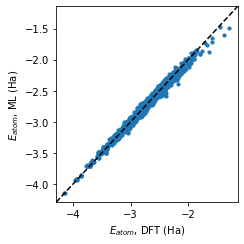

In [22]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

# Plot the actual vs predicted
ax.scatter(data['u0_atom'], data['u0_atom_pred'], s=10)

# Place a y=x line on the graph. We fix
#  the x and y limits first so that they do not
#  re-adjust to create more whitespace after 
#  adding the new line
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('$E_{atom}$, DFT (Ha)')
ax.set_ylabel('$E_{atom}$, ML (Ha)')
fig.tight_layout()

### Fitting Hyperparameters
The key hyperparamter for a KRR model is $\lambda$, which controls the tradeoff between fitness to the training set and model complexity.

Scikit-learn provides a convenient tool, [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), for optimizing hyperparameters that we will use for this exercise.

In [23]:
# GridSearchCV wraps over a model performs hyperparameter optimization when you call fit
#  by re-running the model with a series of different parameters. For efficiency,
#  I wrap the KRR part of the model rather than the whole pipeline so that we do 
#  not need to re-run the kernel code
model = Pipeline([
    ('kernel', FCHLKernel()),
    ('krr', GridSearchCV(
        estimator=KernelRidge(kernel='precomputed'), # Set the estimator to be KRR
        param_grid={'alpha': np.logspace(-8, 0, 32)},  # Lambda is known as alpha in sklearn
        cv=ShuffleSplit(test_size=0.1, random_state=1),  # Use 10, 90/10% splits
        scoring='neg_mean_absolute_error',  # Score based on MAE
    ))
])

In [24]:
%%time
model.fit(train_data['fchl_rep'].tolist(), train_data['u0_atom']);

CPU times: user 18.8 s, sys: 715 ms, total: 19.5 s
Wall time: 5 s


Pipeline(steps=[('kernel', FCHLKernel()),
                ('krr',
                 GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=1, test_size=0.1, train_size=None),
                              estimator=KernelRidge(kernel='precomputed'),
                              param_grid={'alpha': array([1.00000000e-08, 1.81160919e-08, 3.28192787e-08, 5.94557071e-08,
       1.07710506e-07, 1.95129342e-07, 3.53498111e-07, 6.40400427e-07,
       1.16015530e-06, 2.10174801...78538e-06,
       1.24960914e-05, 2.26380341e-05, 4.10112707e-05, 7.42963951e-05,
       1.34596032e-04, 2.43835410e-04, 4.41734470e-04, 8.00250228e-04,
       1.44974067e-03, 2.62636353e-03, 4.75794431e-03, 8.61953566e-03,
       1.56152301e-02, 2.82886943e-02, 5.12480588e-02, 9.28414545e-02,
       1.68192432e-01, 3.04698957e-01, 5.51995432e-01, 1.00000000e+00])},
                              scoring='neg_mean_absolute_error'))])

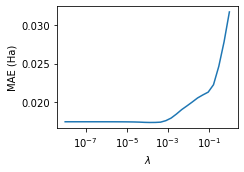

In [25]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

gs = model[1]
ax.semilogx(np.array(gs.cv_results_['param_alpha']), -1*gs.cv_results_['mean_test_score'])

ax.set_xlabel('$\lambda$')
ax.set_ylabel('MAE (Ha)')
fig.tight_layout()

Note how the error can change by about a factor of 2 when we adjust $\lambda$

In [26]:
%%time
data['u0_atom_pred'] = model.predict(data['fchl_rep'].tolist())

CPU times: user 11min 34s, sys: 395 ms, total: 11min 35s
Wall time: 3min


In [27]:
mae = mean_absolute_error(data['u0_atom'], data['u0_atom_pred'])
print(f'MAE = {mae:.4f} Ha = {mae*627.50947406:.2f} kcal/mol')

MAE = 0.0106 Ha = 6.67 kcal/mol


By tuning the hyperparameter, we reduced the error to only 7 kcal/mol!

### Computing a Learning Curve
Learning curves show the improvement of a model as you add more training data.
Here, we demonstrate how to make a learning curve to illustrate a few additional points about FCHL.

In [28]:
# Set up the test sizes we will evaluate for the learning curve
train_sizes = [10, 30, 100, 300, 1000]

In [29]:
# Prepare a standard test set
train_data, test_data = train_test_split(data, test_size=500, random_state=1) 

# Avoids warnings about setting values of a copy
test_data = test_data.copy()

In [30]:
# Loop over the test sizes
results = []
for ts in tqdm(train_sizes):
    # Split off some training data
    train_subset = train_data.sample(ts, random_state=1)
    
    # Fit the model
    train_time = perf_counter()
    model.fit(train_subset['fchl_rep'].tolist(), train_subset['u0_atom'])
    train_time = perf_counter() - train_time
    
    # Evaluate the model on the test set
    test_time = perf_counter()
    test_data['u0_atom_pred'] = model.predict(test_data['fchl_rep'].tolist())
    test_time = perf_counter() - test_time
    
    # Store performance information
    results.append({
        'train_size': ts,
        'train_time': train_time,
        'test_time': test_time,
        'alpha': model[1].best_params_['alpha'],
        'mae': mean_absolute_error(test_data['u0_atom'], test_data['u0_atom_pred'])
    })

100%|██████████| 5/5 [18:42<00:00, 224.49s/it]


In [31]:
results = pd.DataFrame(results)

Step 1: Compare to the original JCP paper

In [32]:
jcp_results = pd.DataFrame([
    [100, 0.2769171852851224], [1005.3012238214807, 0.06426615177922405],
    [2502.606983490659, 0.03831336782897019], [5029.126239917856, 0.02719291345844958],
    [10026.471083195112, 0.01905330215897317], [20148.744549550407, 0.013094302135827789]
], columns=['size', 'mae'])

Text(0, 0.5, 'MAE (eV)')

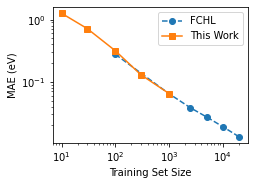

In [33]:
fig, ax = plt.subplots()

ax.loglog(jcp_results['size'], jcp_results['mae'], 'o--', label='FCHL')
ax.loglog(results['train_size'], results['mae'] * 27.2114, 's-', label='This Work')

fig.set_size_inches(3.5, 2.5)
ax.legend()
ax.set_xlabel('Training Set Size')
ax.set_ylabel('MAE (eV)')

Our implementation agrees well with the original paper!

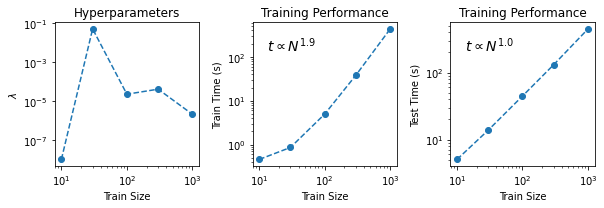

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(8.5, 3.))

ax = axs[0]
ax.loglog(results['train_size'], results['alpha'], '--o')
ax.set_ylabel('$\lambda$')
ax.set_title('Hyperparameters')

ax = axs[1]
ax.loglog(results['train_size'], results['train_time'], '--o')
p = linregress(np.log(results['train_size'].iloc[-3:]), np.log(results['train_time'].iloc[-3:]))
ax.text(0.1, 0.8, f'$t \propto N^{{{p[0]:.1f}}}$', transform=ax.transAxes, fontsize=14)
ax.set_ylabel('Train Time (s)')
ax.set_title('Training Performance')

ax = axs[2]
ax.loglog(results['train_size'], results['test_time'], '--o')
p = linregress(np.log(results['train_size'].iloc[-3:]), np.log(results['test_time'].iloc[-3:]))
ax.text(0.1, 0.8, f'$t \propto N^{{{p[0]:.1f}}}$', transform=ax.transAxes, fontsize=14)
ax.set_ylabel('Test Time (s)')
ax.set_title('Training Performance')

for ax in axs:
    ax.set_xlabel('Train Size')

fig.tight_layout()

We can note a few things:

1. The hyperparameters do change as a function of training set size. Be careful when fitting this model to always re-tune $\lambda$
2. The training time scales with $O(N^2)$ with the number of training entries. The quadratic scaling is a result of the time it takes to compute the kernel matrix
3. The evaluation/test time scales linearly with the training set size, which is driven by the cost of comparing a point to each training entry

## Summary
Going back to our learning objectives, let's review that FHCL is...

- [x] kernel method (*uses features based on similiarity to training set*)
- [x] created with atomistic, scalable kernels (*similarity functions that express atomic contributions to molecular properties*)
- [x] that use "alchemical" many-body similarity functions (*functions that capture similarity between atoms' environments*)
- [x] to regress atomic properties with ridge regression (*using similiarty scores as inputs to a penalized linear regression*).